In [32]:
# Initial imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

  # Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

In [33]:
#set path to Features CSV and read in CSV
amd_df = pd.read_pickle('Resources/amd_features_df.pickle')
amd_df.head()

,AMD Close,AMD Volume,Call Volume,Put Volume,Total Option Volume,Percent of Put,Put signals,Percent of calls,Call signals,bollinger_mid_band,...,bollinger_long,bollinger_short,bollinger_signal,rvol,rvol SD,rvol signal,Option rVol,Option rVol SD,Option rVol signal,daily returns
2019-08-02,29.46,46470316,155666.0,133301.0,288967.0,0.461302,False,0.538698,False,32.94150,...,1.0,0.0,1.0,0.976222,1.053825,0.0,1.000210,1.053825,0.0,-0.013396
2019-08-05,27.98,67551620,177393.0,225181.0,402574.0,0.559353,False,0.440647,False,32.76600,...,1.0,0.0,1.0,1.367475,1.095401,1.0,1.355245,1.095401,1.0,-0.050238
2019-08-06,28.85,52564104,139467.0,77573.0,217040.0,0.357413,False,0.642587,True,32.60600,...,1.0,0.0,1.0,1.055476,1.108734,0.0,0.733816,1.108734,0.0,0.031094
2019-08-07,29.19,51792473,117435.0,72452.0,189887.0,0.381553,False,0.618447,True,32.40850,...,1.0,0.0,1.0,1.045626,1.114328,0.0,0.663929,1.114328,0.0,0.011785
2019-08-08,33.95,154602514,677838.0,295952.0,973790.0,0.303918,False,0.696082,True,32.41675,...,0.0,0.0,0.0,2.831795,1.329637,1.0,3.086563,1.329637,1.0,0.163070


In [34]:
#Create new trading signals Df, Set index as datetime object and drop extraneous columns
trading_signals_df = pd.DataFrame()

In [35]:
#add daily change rates to increase the staionarity of dataset
trading_signals_df['volume delta'] = amd_df['AMD Volume'].dropna().pct_change()
trading_signals_df['bb std delta'] = amd_df['bollinger_std'].dropna().pct_change()
trading_signals_df['rvol delta'] = amd_df['rvol'].dropna().pct_change()
trading_signals_df['option rvol delta'] = amd_df['Option rVol'].dropna().pct_change()

#add daily returns as target
trading_signals_df['daily returns'] = amd_df['daily returns'].dropna()

trading_signals_df= trading_signals_df.dropna()
trading_signals_df.head()

,volume delta,bb std delta,rvol delta,option rvol delta,daily returns
2019-08-05,0.453651,0.287330,0.400783,0.354961,-0.050238
2019-08-06,-0.221868,0.122148,-0.228157,-0.458536,0.031094
2019-08-07,-0.014680,0.073562,-0.009333,-0.095237,0.011785
2019-08-08,1.985038,0.002992,1.708230,3.648932,0.163070
2019-08-09,-0.193041,0.016200,-0.239327,-0.171540,0.006775


In [36]:
 def window_data(window):
    """
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(trading_signals_df) - window):
        features = trading_signals_df.iloc[i : (i + window), :]
        target = trading_signals_df.iloc[(i + window), -1]
        X.append(features)
        y.append(target)
    
    return np.array(X), np.array(y).reshape(-1, 1)

In [37]:
# Define the window size
window_size = 7

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(window_size)



In [38]:
# Manually splitting the data
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [39]:
scalers = {}
for i in range(X_train.shape[1]):
    scalers[i] = MinMaxScaler()
    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 

for i in range(X_test.shape[1]):
    X_test[:, i, :] = scalers[i].transform(X_test[:, i, :])



In [40]:
scaler = MinMaxScaler()
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [41]:
# Define the Transformer model.
model = Sequential()

# Initial model setup
number_units = 7
dropout_fraction = 0.3
inputs = len(trading_signals_df.columns)

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X.shape[1], inputs))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1, activation = 'linear'))

In [42]:
# Compile the LSTM model
model.compile(optimizer="adam", loss="mean_squared_error")

In [43]:
# Show the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 7, 7)              364       
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7)              0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 7, 7)              420       
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7)              0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 7)                 420       
_________________________________________________________________
dropout_5 (Dropout)          (None, 7)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [44]:
 # Train the model
model.fit(X_train, y_train, epochs=100, shuffle=False, verbose=0)

In [45]:
 # Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [56]:
#Recover the original, nonscaled prices
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [59]:
# Create a DataFrame of Real and Predicted values, shifted by forward window
shift =7
stocks = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = trading_signals_df.index[-len(real_prices)-shift:-shift ] )


# Show the DataFrame's head
stocks

,Actual,Predicted
2019-11-12,-0.035863,0.004075
2019-11-13,-0.009131,0.004246
2019-11-14,0.016863,0.003672
2019-11-15,-0.020854,0.002973
2019-11-18,0.011291,0.002527
2019-11-19,-0.006851,0.001402
2019-11-20,-0.010475,-0.000194
2019-11-21,0.003958,-0.001066
2019-11-22,0.020747,-0.001390
2019-11-25,-0.001764,-0.002464


In [60]:
#convert stocks df into positive and negative signals
stocks['Positive Actual signal'] = np.where(stocks['Actual'] > 0, 1, 0)
stocks['Negative Actual signal'] = np.where(stocks['Actual'] < 0, -1, 0)

stocks['Positive Predicted signal'] = np.where(stocks['Predicted'] > 0, 1, 0)
stocks['Negative Predicted signal'] = np.where(stocks['Predicted'] < 0, -1, 0)

#merge to create one column per signal, shifted back to reflect forward projection window
shift = 7
stocks['Actual Signal'] = stocks['Positive Actual signal'] + stocks['Negative Actual signal']
stocks['LSTM Predicted Signal'] = stocks['Positive Predicted signal'] + stocks['Negative Predicted signal']
stocks

,Actual,Predicted,Positive Actual signal,Negative Actual signal,Positive Predicted signal,Negative Predicted signal,Actual Signal,LSTM Predicted Signal
2019-11-12,-0.035863,0.004075,0,-1,1,0,-1,1
2019-11-13,-0.009131,0.004246,0,-1,1,0,-1,1
2019-11-14,0.016863,0.003672,1,0,1,0,1,1
2019-11-15,-0.020854,0.002973,0,-1,1,0,-1,1
2019-11-18,0.011291,0.002527,1,0,1,0,1,1
2019-11-19,-0.006851,0.001402,0,-1,1,0,-1,1
2019-11-20,-0.010475,-0.000194,0,-1,0,-1,-1,-1
2019-11-21,0.003958,-0.001066,1,0,0,-1,1,-1
2019-11-22,0.020747,-0.001390,1,0,0,-1,1,-1
2019-11-25,-0.001764,-0.002464,0,-1,0,-1,-1,-1


In [61]:
stocks['LSTM Predicted Signal'].to_pickle(r'C:\Users\Kiel\Desktop\FINTECH\UCB_fintech_homework\project_2 - local\Resources\LSTM_signals_df.pickle')

<AxesSubplot:>

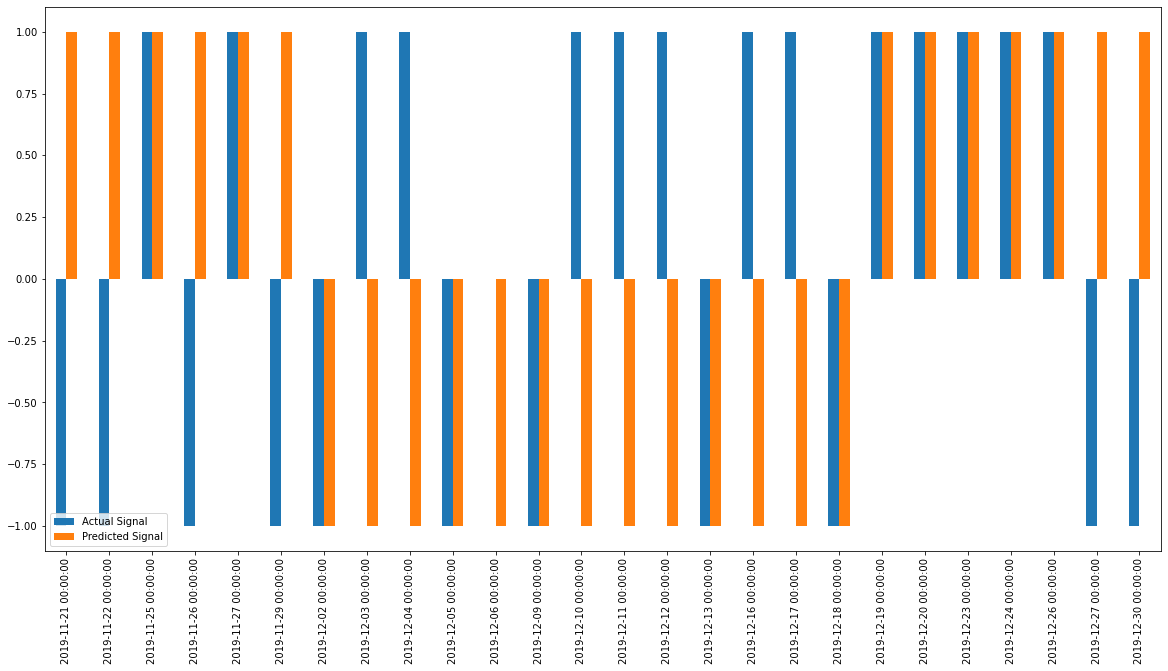

In [20]:
stocks.plot(y = ['Actual Signal', 'Predicted Signal'], figsize = (20,10), kind = 'bar')

<AxesSubplot:>

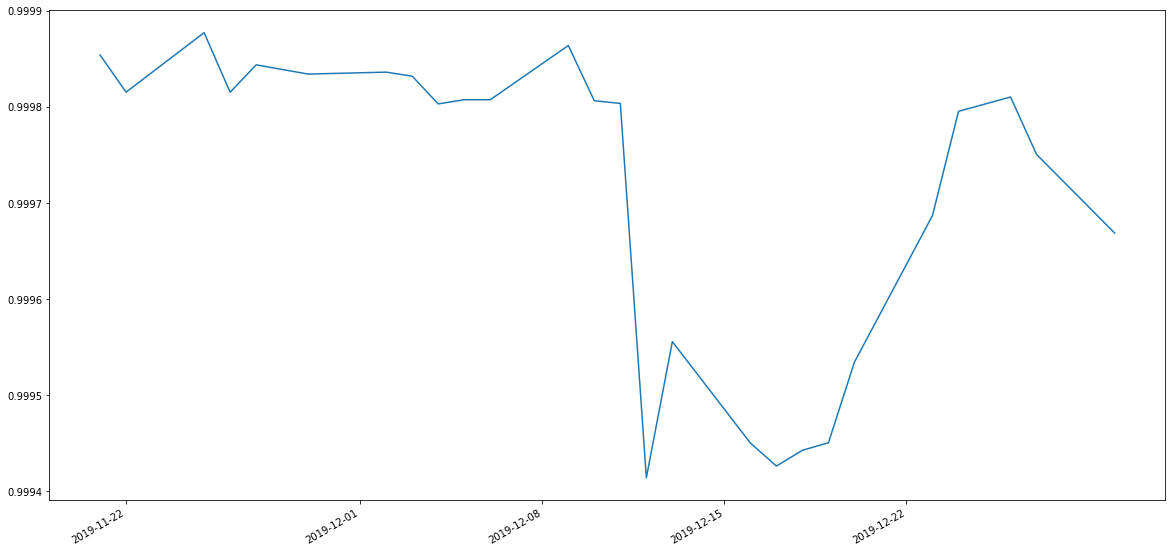

In [21]:
# Calculate cumulative return of model and plot the result
(1 + (stocks['Actual'] * stocks['Predicted'])).cumprod().plot(figsize = (20,10))

<AxesSubplot:>

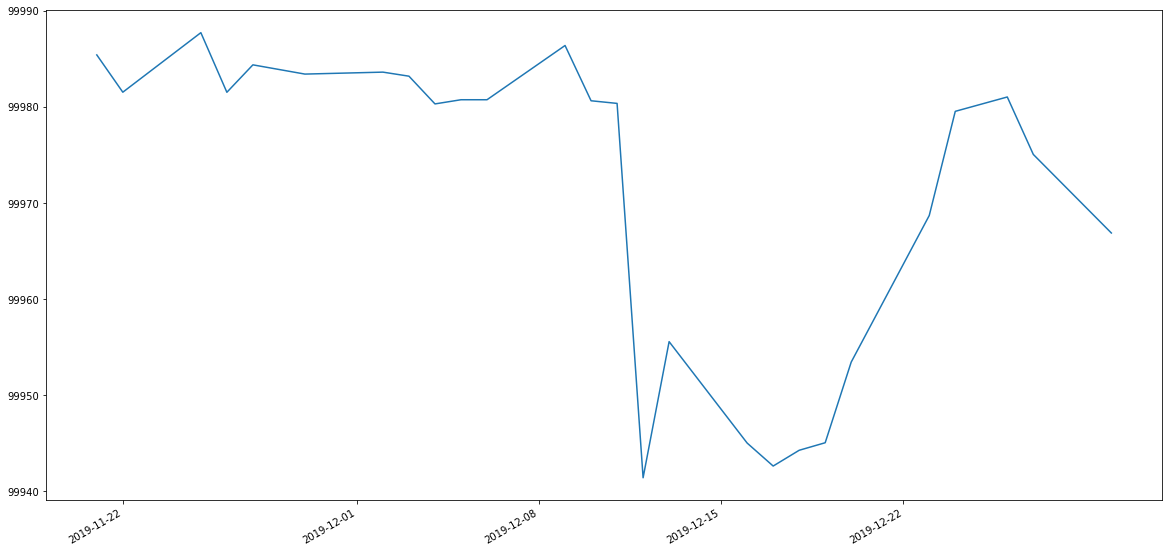

In [22]:
# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (stocks['Actual'] * stocks['Predicted'])).cumprod()
cumulative_return_capital.plot(figsize = (20,10))